## Helper Functions and imports

### Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import datetime
import os
import optuna
%matplotlib inline

# Force TensorFlow to use CPU only
#tf.config.set_visible_devices([], 'GPU')

# Ensure that TensorFlow doesn't allocate memory on the GPU
#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('CPU')[0], True)

# Allow memory growth on GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
from cycler import cycler

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
#from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard # Callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, \
                                    Flatten, RandomFlip, RandomRotation,RandomZoom, \
                                    BatchNormalization, Activation # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

# Set mixed precision policy for faster running times
from tensorflow.keras import mixed_precision as mp
mp.set_global_policy("mixed_float16")

2024-03-14 22:47:38.643968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 22:47:38.666233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 22:47:38.666250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 22:47:38.666868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 22:47:38.670613: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


2024-03-14 22:47:40.017745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:47:40.039405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:47:40.039524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Helper Functions

In [2]:
# Plot the results
def plot_history(hs, metric):
    print()
    #plt.style.use('light_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    
    # Set colorblind-friendly colors
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    
    # Change background to white
    plt.style.use('tableau-colorblind10')

    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    #x_ticks = np.arange(0, epochs + 1, epochs / 10)
    #x_ticks [0] += 1
    #plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

# Clean up the model
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

# Evaluate all models from folder

def evaluate_models_in_folder(folder_path, X, Y, verbose=1):
    """
    Evaluate all models in the specified folder on the given input data (X) and target data (Y).
    
    Parameters:
        folder_path (str): The path to the folder containing the model files.
        X (numpy.ndarray): The input data.
        Y (numpy.ndarray): The target data.
        verbose (int): Verbosity mode (0 or 1).

    Returns:
        dict: A dictionary containing model filenames as keys and evaluation results as values.
    """
    # Dictionary to store evaluation results
    results = {}
    
    # Get the list of files in the folder
    model_files = [file for file in os.listdir(folder_path) if file.endswith("model.keras")]

    # Iterate over each model file
    for model_file in model_files:
        # Construct the full path to the model file
        model_path = os.path.join(folder_path, model_file)
        
        # Load the model
        model = tf.keras.models.load_model(model_path)
        
        # Evaluate the model on the test data
        evaluation_result = model.evaluate(X, Y, verbose=verbose)
        
        # Store the evaluation result in the dictionary
        results[model_file] = evaluation_result

    # Sort the dictionary by accuracy
    sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1][1], reverse=True)}

    for model_file, evaluation_result in sorted_results.items():
        print(f"Model: {model_file}, Accuracy: {evaluation_result[1]:.4f}")

    return sorted_results

# Fashion-MNIST

## Load Fashion-MNIST Data from Tensorflow and Preprocess

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


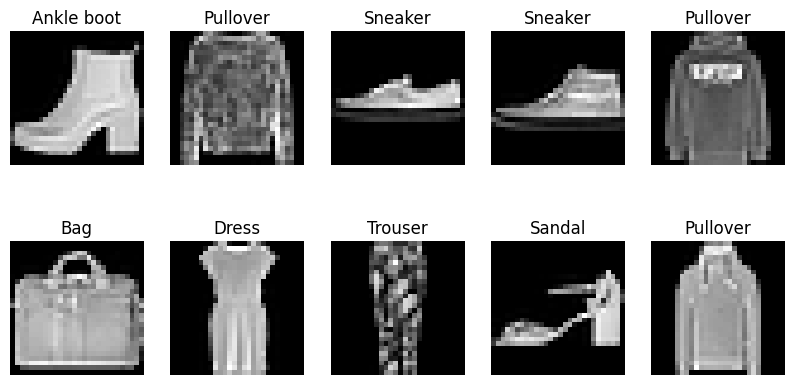

In [4]:
# Load Fashion MNIST dataset
(train_images_fmnist, train_labels_fmist), (test_images_fmnist, test_labels_fmnist) = tf.keras.datasets.fashion_mnist.load_data()

# Print shapes of the loaded data
print("Training images shape:", train_images_fmnist.shape)
print("Training labels shape:", train_labels_fmist.shape)
print("Testing images shape:", test_images_fmnist.shape)
print("Testing labels shape:", test_labels_fmnist.shape)

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot 10 random examples with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(0, train_images_fmnist.shape[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images_fmnist[idx], cmap='gray')
    plt.title(class_names[train_labels_fmist[idx]])
    plt.axis('off')

plt.show()

## MLP

### Dataset Preprocessing for MLP Fashion MNIST

In [5]:
X_train_mlp_fmnist = train_images_fmnist.reshape(60000, 28*28)/255
X_test_mlp_fmnist = test_images_fmnist.reshape(10000, 28*28)/255
X_train_mlp_fmnist = X_train_mlp_fmnist.astype('float32')
X_test_mlp_fmnist = X_test_mlp_fmnist.astype('float32')
Y_train_mlp_fmnist = to_categorical(train_labels_fmist, num_classes= 10)
Y_test_mlp_fmnist = to_categorical(test_labels_fmnist, num_classes= 10)

### Train MLP Fashion MNIST

In [6]:
def train_model_mlp_fmnist(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_units = 256,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        dropout_rate = 0.5,
        verbose=1,
        use_custom_callback=False, # if true please provide your custom callbacks list
        callbacks_list = [],
        save_model = True,
        print_summary=True,
        model_path="mlp_fmnist",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.

    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=(28*28,),
        name='Input'
    )

    x = input
    
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=hidden_units,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Add Dropout layer
        x = Dropout(
            rate=dropout_rate,
            name='Dropout-{0:d}'.format(i+1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    if not use_custom_callback:
       
        # Define callbacks list and paths
        log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))
        checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
        
        callbacks_list = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                verbose=1,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
            ),
            TensorBoard(
                log_dir=log_dir,
                histogram_freq = 1,
                profile_batch = '500,520'
            )
        ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
#                  loss='sparce_categorical_crossentropy', # check also if we need to use that
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    if print_summary: model.summary() 
    
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, #callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')


    if save_model:
        # Save the model
        model.save(os.path.join(model_path, run_name+"model.keras"))
    
        # Save the training history
        with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
            pickle.dump(hs, file)

    return model, hs


### Run MLP model

In [7]:
optimizer = Adam() #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="mlp_fmnist"
run_name="dropout0.3+5Dense+Batchsize64+constUnits_"

# MLP
mlp_model_fmnist, mlp_hs_fmnist = train_model_mlp_fmnist(
    train_data=X_train_mlp_fmnist,
    train_labels=Y_train_mlp_fmnist,
    optimizer=optimizer,
    epochs=100,
    batch_size=64,
    hidden_layers=5,
    hidden_activation='gelu',
    output_activation='softmax',
    dropout_rate=0.3,
    verbose=1,
    use_custom_callback=False, # if true please provide your custom callbacks list
    callbacks_list = [],
    save_model = True,
    print_summary=True,
    model_path=model_path,
    run_name=run_name
)

Model: "mlp_fmnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Hidden-1 (Dense)            (None, 256)               200960    
                                                                 
 Dropout-1 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-2 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-2 (Dropout)         (None, 256)               0         
                                                                 
 Hidden-3 (Dense)            (None, 256)               65792     
                                                                 
 Dropout-3 (Dropout)         (None, 256)               0

2024-03-14 22:14:14.668192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:14:14.668421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:14:14.668543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-03-14 22:14:18.399918: I external/local_xla/xla/service/service.cc:168] XLA service 0x78c7b40034c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 22:14:18.399949: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-14 22:14:18.407075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 22:14:18.668191: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710447258.724584    5517 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


534/844 [=================>............] - ETA: 1s - loss: 0.6844 - accuracy: 0.7475

2024-03-14 22:14:21.347994: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:14:21.348014: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:14:21.348023: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:14:21.348026: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:14:21.348028: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:14:21.348030: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-14 22:14:21.429789: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

844/844 [==============================] - 7s 5ms/step - loss: 0.6084 - accuracy: 0.7784 - val_loss: 0.4149 - val_accuracy: 0.8515
Epoch 2/100
844/844 [==============================] - 4s 5ms/step - loss: 0.4426 - accuracy: 0.8428 - val_loss: 0.3791 - val_accuracy: 0.8588
Epoch 3/100
844/844 [==============================] - 4s 5ms/step - loss: 0.4060 - accuracy: 0.8551 - val_loss: 0.3550 - val_accuracy: 0.8643
Epoch 4/100
844/844 [==============================] - 3s 4ms/step - loss: 0.3870 - accuracy: 0.8620 - val_loss: 0.3519 - val_accuracy: 0.8705
Epoch 5/100
844/844 [==============================] - 4s 5ms/step - loss: 0.3711 - accuracy: 0.8665 - val_loss: 0.3517 - val_accuracy: 0.8743
Epoch 6/100
844/844 [==============================] - 4s 5ms/step - loss: 0.3621 - accuracy: 0.8701 - val_loss: 0.3369 - val_accuracy: 0.8780
Epoch 7/100
844/844 [==============================] - 4s 5ms/step - loss: 0.3515 - accuracy: 0.8736 - val_loss: 0.3482 - val_accuracy: 0.8833
Epoch 8/100

313/313 [==============================] - 0s 1ms/step - loss: 0.3423 - accuracy: 0.8844



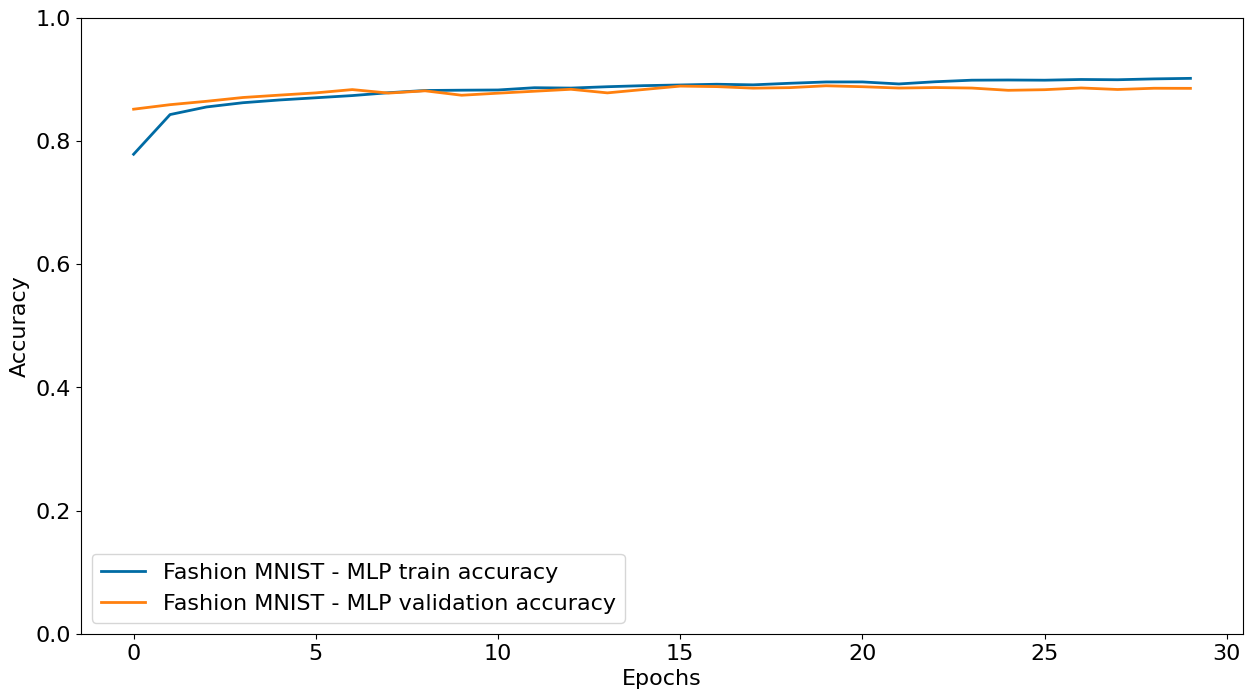

In [8]:
# # Load model and evaluate on test data. Show all the results.
# model = tf.keras.models.load_model("mlp_fmnist/with_dropout0.5_model.keras")
# mlp_eval_fmnist = model.evaluate(X_test, Y_test, verbose=1)

# # Load and plot the history
# with open('mlp_fmnist/with_dropout0.5_history.pkl', 'rb') as file:
#     loaded_history = pickle.load(file)

mlp_model_fmnist.evaluate(X_test_mlp_fmnist, Y_test_mlp_fmnist, verbose=1)

plot_history(hs={'Fashion MNIST - MLP': mlp_hs_fmnist}, metric='accuracy')

In [11]:
# Evaluate all models
_ = evaluate_models_in_folder("mlp_fmnist/", X_test_mlp_fmnist, Y_test_mlp_fmnist, verbose=0)

Model: _with_dropout0.3_model.keras, Accuracy: 0.8968
Model: dropout0.3+5Dense+Batchsize256+constUnits_model.keras, Accuracy: 0.8968
Model: model.keras, Accuracy: 0.8919
Model: dropout0.3+3Dense+Batchsize256_model.keras, Accuracy: 0.8908
Model: with_dropout0.5_model.keras, Accuracy: 0.8892
Model: dropout0.3+5Dense+Batchsize256_model.keras, Accuracy: 0.8879
Model: dropout0.3+5Dense+Batchsize64+constUnits_model.keras, Accuracy: 0.8844
Model: dropout0.5+3Dense+Batchsize128_model.keras, Accuracy: 0.8841
Model: dropout0.5+3Dense+Batchsize64_model.keras, Accuracy: 0.8706


### Hyperparameter tuning with Optuna - MLP Fashion MNIST

In [12]:
def objective_mlp_fmnist(trial):

    tf.keras.backend.clear_session()

    callbacks_list = [
        EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=True)
    ]

    
    # Parameters to search
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    hidden_units = trial.suggest_categorical('hidden_units',[64,128,256,512])
    hidden_activation = trial.suggest_categorical('hidden_activation', ['relu', 'gelu'])
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.5, step=0.1)
    lr = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3])
    
    optimizer = Adam(learning_rate=lr) #standard learning rate
    optimizer = mp.LossScaleOptimizer(optimizer)

    # MLP
    _, hs = train_model_mlp_fmnist(
        train_data=X_train_mlp_fmnist,
        train_labels=Y_train_mlp_fmnist,
        optimizer=optimizer,
        epochs=100,
        batch_size=batch_size,
        hidden_layers=hidden_layers,
        hidden_activation=hidden_activation,
        output_activation='softmax',
        dropout_rate=dropout_rate,
        verbose=1,
        use_custom_callback=True, # if true please provide your custom callbacks list
        callbacks_list = callbacks_list,
        save_model = False,
        print_summary=False,
        model_path=model_path,
        run_name=run_name
    )

    val_accuracy = hs.history['val_accuracy'][-1]
    
    return val_accuracy
    

In [ ]:
# Define the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp_fmnist, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

[I 2024-03-12 19:54:18,004] A new study created in memory with name: no-name-e0022c6c-9152-48be-a21e-c6c25d428941


Epoch 1/100
422/422 [==============================] - 2s 4ms/step - loss: 2.2884 - accuracy: 0.1315 - val_loss: 2.2228 - val_accuracy: 0.2152
Epoch 2/100
422/422 [==============================] - 2s 4ms/step - loss: 2.2263 - accuracy: 0.1914 - val_loss: 2.1495 - val_accuracy: 0.2957
Epoch 3/100
422/422 [==============================] - 1s 3ms/step - loss: 2.1614 - accuracy: 0.2485 - val_loss: 2.0737 - val_accuracy: 0.3808
Epoch 4/100
422/422 [==============================] - 1s 3ms/step - loss: 2.0939 - accuracy: 0.2949 - val_loss: 1.9916 - val_accuracy: 0.4447
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 2.0180 - accuracy: 0.3393 - val_loss: 1.9025 - val_accuracy: 0.5000
Epoch 6/100
422/422 [==============================] - 1s 3ms/step - loss: 1.9370 - accuracy: 0.3788 - val_loss: 1.8075 - val_accuracy: 0.5455
Epoch 7/100
422/422 [==============================] - 1s 3ms/step - loss: 1.8511 - accuracy: 0.4172 - val_loss: 1.7102 - val_accuracy: 0.5848

[I 2024-03-12 19:56:39,256] Trial 0 finished with value: 0.8211666941642761 and parameters: {'batch_size': 128, 'hidden_layers': 4, 'hidden_units': 128, 'hidden_activation': 'relu', 'dropout': 0.1361024779262004, 'learning_rate': 1e-06}. Best is trial 0 with value: 0.8211666941642761.


Finished training.
------------------
Epoch 1/100
844/844 [==============================] - 3s 3ms/step - loss: 2.3610 - accuracy: 0.1133 - val_loss: 2.2253 - val_accuracy: 0.2172
Epoch 2/100
844/844 [==============================] - 2s 3ms/step - loss: 2.2716 - accuracy: 0.1502 - val_loss: 2.1333 - val_accuracy: 0.3397
Epoch 3/100
844/844 [==============================] - 2s 3ms/step - loss: 2.1928 - accuracy: 0.1967 - val_loss: 2.0444 - val_accuracy: 0.4682
Epoch 4/100
844/844 [==============================] - 2s 3ms/step - loss: 2.1206 - accuracy: 0.2379 - val_loss: 1.9549 - val_accuracy: 0.5455
Epoch 5/100
844/844 [==============================] - 2s 3ms/step - loss: 2.0500 - accuracy: 0.2825 - val_loss: 1.8648 - val_accuracy: 0.5792
Epoch 6/100
844/844 [==============================] - 2s 3ms/step - loss: 1.9822 - accuracy: 0.3159 - val_loss: 1.7767 - val_accuracy: 0.5993
Epoch 7/100
844/844 [==============================] - 2s 3ms/step - loss: 1.9095 - accuracy: 0.3494 - v

[I 2024-03-12 20:00:22,588] Trial 1 finished with value: 0.8061666488647461 and parameters: {'batch_size': 64, 'hidden_layers': 3, 'hidden_units': 64, 'hidden_activation': 'relu', 'dropout': 0.3800812874474701, 'learning_rate': 1e-06}. Best is trial 0 with value: 0.8211666941642761.


Finished training.
------------------
Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 2.3191 - accuracy: 0.1568 - val_loss: 2.0830 - val_accuracy: 0.3722
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 2.0833 - accuracy: 0.2679 - val_loss: 1.8658 - val_accuracy: 0.5477
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.8928 - accuracy: 0.3820 - val_loss: 1.6740 - val_accuracy: 0.6327
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.7309 - accuracy: 0.4564 - val_loss: 1.5001 - val_accuracy: 0.6667
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 1.5872 - accuracy: 0.5093 - val_loss: 1.3491 - val_accuracy: 0.6822
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.4666 - accuracy: 0.5411 - val_loss: 1.2273 - val_accuracy: 0.6880
Epoch 7/100
1688/1688 [==============================] - 4s 3ms/step - loss: 1.3673 - accura

[I 2024-03-12 20:07:42,632] Trial 2 finished with value: 0.8376666903495789 and parameters: {'batch_size': 32, 'hidden_layers': 2, 'hidden_units': 64, 'hidden_activation': 'relu', 'dropout': 0.3490153126266937, 'learning_rate': 1e-06}. Best is trial 2 with value: 0.8376666903495789.


Finished training.
------------------
Epoch 1/100
1688/1688 [==============================] - 6s 4ms/step - loss: 2.3464 - accuracy: 0.1285 - val_loss: 2.0794 - val_accuracy: 0.3002
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.9592 - accuracy: 0.3460 - val_loss: 1.7669 - val_accuracy: 0.5565
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.6981 - accuracy: 0.5073 - val_loss: 1.5341 - val_accuracy: 0.6332
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.4964 - accuracy: 0.5832 - val_loss: 1.3568 - val_accuracy: 0.6723
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 1.3433 - accuracy: 0.6259 - val_loss: 1.2209 - val_accuracy: 0.6927
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.2292 - accuracy: 0.6475 - val_loss: 1.1178 - val_accuracy: 0.7095
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.1426 - accura

[I 2024-03-12 20:15:06,897] Trial 3 finished with value: 0.8378333449363708 and parameters: {'batch_size': 32, 'hidden_layers': 1, 'hidden_units': 512, 'hidden_activation': 'relu', 'dropout': 0.23763532027001327, 'learning_rate': 1e-06}. Best is trial 3 with value: 0.8378333449363708.


Finished training.
------------------
Epoch 1/100
844/844 [==============================] - 3s 3ms/step - loss: 2.4293 - accuracy: 0.1111 - val_loss: 2.2399 - val_accuracy: 0.1708
Epoch 2/100
844/844 [==============================] - 2s 3ms/step - loss: 2.1846 - accuracy: 0.2047 - val_loss: 2.0293 - val_accuracy: 0.3550
Epoch 3/100
844/844 [==============================] - 2s 2ms/step - loss: 1.9948 - accuracy: 0.3159 - val_loss: 1.8535 - val_accuracy: 0.4938
Epoch 4/100
844/844 [==============================] - 2s 2ms/step - loss: 1.8351 - accuracy: 0.4145 - val_loss: 1.6991 - val_accuracy: 0.5795
Epoch 5/100
844/844 [==============================] - 2s 2ms/step - loss: 1.6930 - accuracy: 0.4909 - val_loss: 1.5640 - val_accuracy: 0.6237
Epoch 6/100
844/844 [==============================] - 2s 2ms/step - loss: 1.5723 - accuracy: 0.5372 - val_loss: 1.4476 - val_accuracy: 0.6453
Epoch 7/100
844/844 [==============================] - 2s 2ms/step - loss: 1.4701 - accuracy: 0.5723 - v

[I 2024-03-12 20:18:25,300] Trial 4 finished with value: 0.8203333616256714 and parameters: {'batch_size': 64, 'hidden_layers': 1, 'hidden_units': 256, 'hidden_activation': 'gelu', 'dropout': 0.4218516146260559, 'learning_rate': 1e-06}. Best is trial 3 with value: 0.8378333449363708.


Finished training.
------------------


## CNN

### Dataset Preprocessing for CNN Fashion MNIST

In [13]:
X_train_cnn_fmnist = train_images_fmnist.reshape(60000, 28,28,1)/255
X_test_cnn_fmnist = test_images_fmnist.reshape(10000, 28,28,1)/255
input_shape_cnn_fmnist = (28,28,1) # 1 channel and 28x28 size
X_train_cnn_fmnist = X_train_cnn_fmnist.astype('float32')
X_test_cnn_fmnist = X_test_cnn_fmnist.astype('float32')

Y_train_cnn_fmnist = to_categorical(train_labels_fmist, num_classes= 10)
Y_test_cnn_fmnist = to_categorical(test_labels_fmnist, num_classes= 10)

### Train CNN Fashion MNIST

In [19]:
def train_model_cnn_fmnist(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=64,
        data_augmentation=False,
        batch_normalization=False,
        num_filters=8,
        conv_layers=0,
        conv_activation='relu',
        conv_dropout=False,
        dropout_rate=0.2,
        output_activation='softmax',
        verbose=1,
        use_custom_callback=False, # if true please provide your custom callbacks list
        callbacks_list = [],
        save_model = True,
        print_summary=True,
        model_path="cnn_fmnist",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=input_shape_cnn_fmnist,
        name='Input'
    )

    if data_augmentation:
        x = RandomFlip("horizontal")(input)
        x = RandomRotation(0.1)(x)
        x = RandomZoom(0.2)(x)
    else:
        x = input

    
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=num_filters*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            use_bias = not batch_normalization,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        
        if batch_normalization: x = BatchNormalization(name='BatchNorm-{0:d}'.format(i + 1))(x)
            
        x = Activation(activation=conv_activation)(x)

        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=dropout_rate,
                name='Conv_Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    #x = Dropout(dropout_rate)(x)

    # Add also a Dense layer
    x = Dense(128, name='Dense-{:d}'.format(1))(x)
    #x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(1))(x)
    #x = Dense(128,name='Dense-{:d}'.format(2))(x)
    x = BatchNormalization(name='BatchNorm-Dense'.format(i + 1))(x)
    x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(2))(x)
    
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)


    if not use_custom_callback:
       
        # Define callbacks list and paths
        log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))
        checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
        
        callbacks_list = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                verbose=1,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
            ),
            TensorBoard(
                log_dir=log_dir,
                histogram_freq = 1,
                profile_batch = '500,520'
            )
        ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', # check also if we need to use that
#                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    if print_summary: model.summary() 
    
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, # callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')

    if save_model:
        # Save the model
        model.save(os.path.join(model_path, run_name+"model.keras"))
    
        # Save the training history
        with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
            pickle.dump(hs, file)

    return model, hs


### Run CNN model

In [20]:
optimizer = Adam() #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="cnn_fmnist"
run_name="batch128+dropout02+4conv+BatchNorm+32filters+1Dense_v2_"

# CNN
cnn_model_fmnist, cnn_hs_fmnist = train_model_cnn_fmnist(
    train_data=X_train_cnn_fmnist,
    train_labels=Y_train_cnn_fmnist,
    optimizer=optimizer,
    epochs=100,
    batch_size=128,
    data_augmentation=False,
    num_filters=32,
    conv_layers=4,
    conv_activation='gelu',
    conv_dropout=True,
    batch_normalization=True,
    dropout_rate=0.2,
    output_activation='softmax',
    verbose=1,
    use_custom_callback=False,
    callbacks_list= [],
    save_model=True,
    print_summary=True,
    model_path=model_path,
    run_name=run_name
)

Model: "cnn_fmnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 32)        288       
                                                                 
 BatchNorm-1 (BatchNormaliz  (None, 28, 28, 32)        128       
 ation)                                                          
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 32)        0         
                                                                 
 Conv_Dropout-1 (Dropout)    (None, 14, 14, 32)        0         
                                                        

2024-03-14 22:27:35.453559: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:27:35.453579: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:27:35.453595: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:27:35.453598: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:27:35.453600: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:27:35.453602: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-14 22:27:35.453616: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

422/422 [==============================] - 13s 20ms/step - loss: 0.5350 - accuracy: 0.8059 - val_loss: 2.6431 - val_accuracy: 0.1898
Epoch 2/100
 90/422 [=====>........................] - ETA: 5s - loss: 0.3523 - accuracy: 0.8704

2024-03-14 22:27:49.571913: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:27:49.571957: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:27:49.571979: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:27:49.571987: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:27:49.571993: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:27:49.571999: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


106/422 [======>.......................] - ETA: 5s - loss: 0.3513 - accuracy: 0.8716

2024-03-14 22:27:50.109031: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-03-14 22:27:50.114936: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2024-03-14 22:27:50.114953: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:27:50.114956: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:2026] function cupti_interface_->Finalize()failed with error 
2024-03-14 22:27:50.141472: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:27:50.141489: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:27:50.141493: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuT

422/422 [==============================] - 7s 17ms/step - loss: 0.3408 - accuracy: 0.8754 - val_loss: 0.2658 - val_accuracy: 0.9057
Epoch 3/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2974 - accuracy: 0.8916 - val_loss: 0.2901 - val_accuracy: 0.8958
Epoch 4/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2691 - accuracy: 0.9011 - val_loss: 0.2251 - val_accuracy: 0.9147
Epoch 5/100
422/422 [==============================] - 7s 16ms/step - loss: 0.2485 - accuracy: 0.9092 - val_loss: 0.2312 - val_accuracy: 0.9162
Epoch 6/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2320 - accuracy: 0.9146 - val_loss: 0.2244 - val_accuracy: 0.9222
Epoch 7/100
422/422 [==============================] - 7s 16ms/step - loss: 0.2219 - accuracy: 0.9187 - val_loss: 0.2325 - val_accuracy: 0.9137
Epoch 8/100
422/422 [==============================] - 7s 17ms/step - loss: 0.2127 - accuracy: 0.9216 - val_loss: 0.2111 - val_accuracy: 0.9222
Epoc

313/313 [==============================] - 1s 3ms/step - loss: 0.2180 - accuracy: 0.9291



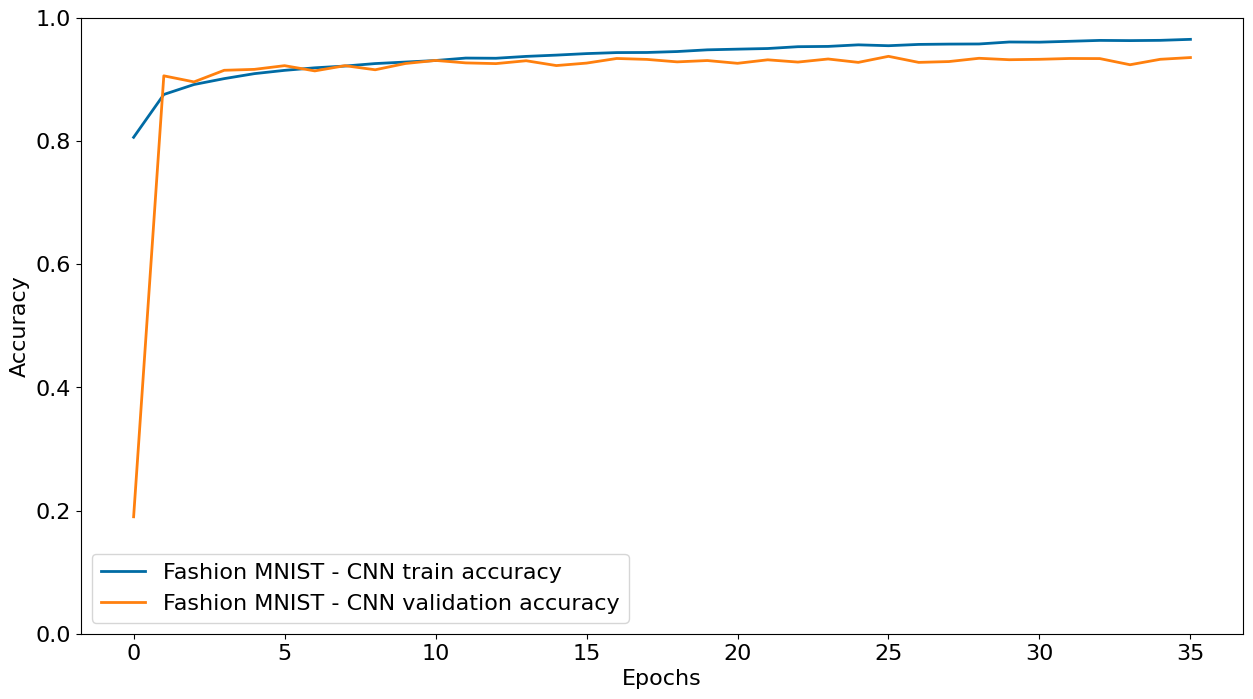

In [22]:
# Evaluate and plot history
cnn_model_fmnist.evaluate(X_test_cnn_fmnist, Y_test_cnn_fmnist, verbose=1)

plot_history(hs={'Fashion MNIST - CNN': cnn_hs_fmnist}, metric='accuracy')

In [21]:
# Evaluate all models
#_ = evaluate_models_in_folder("cnn_fmnist", X_test, Y_test, verbose=0)

In [23]:
tf.keras.backend.clear_session()

### Hyperparameter tuning with Optuna - CNN Fashion MNIST

In [8]:
def objective_cnn_fmnist(trial):

    tf.keras.backend.clear_session()

    callbacks_list = [
        EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=True)
    ]

    
    # Parameters to search
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    conv_layers = trial.suggest_int('hidden_layers', 2, 6, log=True)
    conv_activation = trial.suggest_categorical('hidden_activation', ['relu', 'gelu'])
    conv_filters = trial.suggest_categorical('filters',[8,16,32])
    conv_dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4])
    
    # Train the model
    optimizer = Adam(learning_rate=lr) 
    optimizer = mp.LossScaleOptimizer(optimizer)
     
    # CNN
    _ , hs = train_model_cnn_fmnist(
        train_data=X_train_cnn_fmnist,
        train_labels=Y_train_cnn_fmnist,
        optimizer=optimizer,
        epochs=100,
        batch_size=batch_size,
        data_augmentation=False,
        num_filters=conv_filters,
        conv_layers=conv_layers,
        conv_activation=conv_activation,
        conv_dropout=True,
        batch_normalization=True,
        dropout_rate=conv_dropout,
        output_activation='softmax',
        verbose=0,
        use_custom_callback=True,
        callbacks_list= callbacks_list,
        print_summary=False,
        save_model=False
    )
        
    val_accuracy = hs.history['val_accuracy'][-1]
    return val_accuracy
    

In [9]:
# Define the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_cnn_fmnist, n_trials=15)

# Get the best hyperparameters
best_params = study.best_params

[I 2024-03-11 22:17:24,002] A new study created in memory with name: no-name-a6715e24-adac-484b-8564-958680624247
2024-03-11 22:17:24.007219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 22:17:24.007387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 22:17:24.007452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

Finished training.
------------------


[I 2024-03-11 22:46:11,748] Trial 1 finished with value: 0.7526666522026062 and parameters: {'batch_size': 32, 'hidden_layers': 3, 'hidden_activation': 'relu', 'filters': 16, 'dropout': 0.06776947427939417, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7526666522026062.


Finished training.
------------------


[I 2024-03-11 22:47:34,726] Trial 2 finished with value: 0.10466666519641876 and parameters: {'batch_size': 64, 'hidden_layers': 5, 'hidden_activation': 'relu', 'filters': 8, 'dropout': 0.38755507880463025, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7526666522026062.


Finished training.
------------------


[I 2024-03-11 23:04:58,363] Trial 3 finished with value: 0.6733333468437195 and parameters: {'batch_size': 32, 'hidden_layers': 2, 'hidden_activation': 'gelu', 'filters': 8, 'dropout': 0.28631460190638225, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7526666522026062.


Finished training.
------------------


[I 2024-03-11 23:35:14,818] Trial 4 finished with value: 0.6959999799728394 and parameters: {'batch_size': 16, 'hidden_layers': 3, 'hidden_activation': 'relu', 'filters': 8, 'dropout': 0.39090616444523224, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.7526666522026062.


Finished training.
------------------


[I 2024-03-11 23:39:50,871] Trial 5 finished with value: 0.09683333337306976 and parameters: {'batch_size': 16, 'hidden_layers': 4, 'hidden_activation': 'relu', 'filters': 8, 'dropout': 0.4448145596717858, 'learning_rate': 1e-06}. Best is trial 1 with value: 0.7526666522026062.


Finished training.
------------------


[W 2024-03-12 00:20:26,812] Trial 6 failed with parameters: {'batch_size': 16, 'hidden_layers': 5, 'hidden_activation': 'relu', 'filters': 16, 'dropout': 0.13668311847962933, 'learning_rate': 1e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/vassilis/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_55351/788162058.py", line 27, in objective
    _ , hs = train_model_cnn_fmnist(
  File "/tmp/ipykernel_55351/405952977.py", line 130, in train_model_cnn_fmnist
    hs = model.fit(
  File "/home/vassilis/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/vassilis/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/vassilis/.local/lib/python3.10/site-packages/

KeyboardInterrupt: 

# CIFAR10

## Loading CIFAR10 Data from Tensorflow and Preprocess

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing images shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


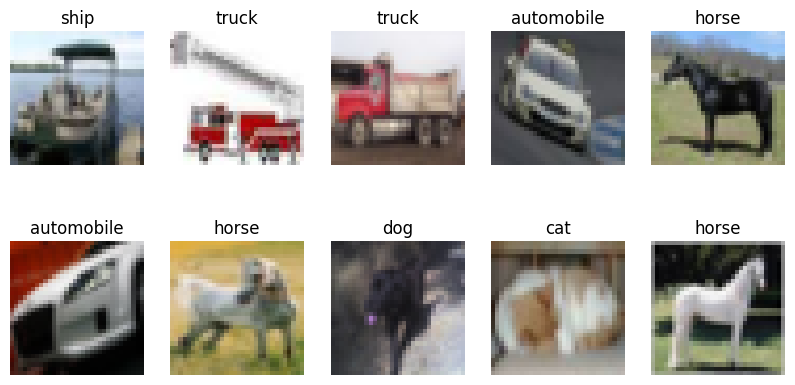

In [3]:
# Load CIFAR-10 dataset
(train_images_cifar10, train_labels_cifar10), (test_images_cifar10, test_labels_cifar10) = tf.keras.datasets.cifar10.load_data()

# Print shapes of the loaded data
print("Training images shape:", train_images_cifar10.shape)
print("Training labels shape:", train_labels_cifar10.shape)
print("Testing images shape:", test_images_cifar10.shape)
print("Testing labels shape:", test_labels_cifar10.shape)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot 10 random examples with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(0, train_images_cifar10.shape[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images_cifar10[idx])
    plt.title(class_names[train_labels_cifar10[idx][0]])
    plt.axis('off')
plt.show()

## MLP

### Dataset Preprocessing for MLP CIFAR-10

In [6]:
X_train_mlp_cifar10 = train_images_cifar10.reshape(50000, 32*32*3)/255
X_test_mlp_cifar10 = test_images_cifar10.reshape(10000, 32*32*3)/255
X_train_mlp_cifar10 = X_train_mlp_cifar10.astype('float32')
X_test_mlp_cifar10 = X_test_mlp_cifar10.astype('float32')
Y_train_mlp_cifar10 = to_categorical(train_labels_cifar10, num_classes=10)
Y_test_mlp_cifar10 = to_categorical(test_labels_cifar10, num_classes=10)

### Train MLP CIFAR-10

In [5]:
def train_model_mlp_cifar10(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_units = 256,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        dropout_rate = 0.5,
        verbose=1,
        use_custom_callback=False, # if true please provide your custom callbacks list
        callbacks_list = [],
        save_model = True,
        print_summary=True,
        model_path="mlp_cifar10",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.

    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=(32*32*3,),
        name='Input'
    )

    x = input
    
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=hidden_units,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Add Dropout layer
        x = Dropout(
            rate=dropout_rate,
            name='Dropout-{0:d}'.format(i+1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    if not use_custom_callback:
       
        # Define callbacks list and paths
        log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))
        checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
        
        callbacks_list = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                verbose=1,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
            ),
            TensorBoard(
                log_dir=log_dir,
                histogram_freq = 1,
                profile_batch = '500,520'
            )
        ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
#                  loss='sparce_categorical_crossentropy', # check also if we need to use that
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    if print_summary: model.summary() 
    
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, #callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')


    if save_model:
        # Save the model
        model.save(os.path.join(model_path, run_name+"model.keras"))
    
        # Save the training history
        with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
            pickle.dump(hs, file)

    return model, hs


### Run MLP model

In [7]:
optimizer = Adam(learning_rate=1e-3) #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="mpl_cifar10"
run_name="lr1e-3+dropout0.2+5Dense+Batchsize128+constUnits512_"

# MLP
mlp_model_cifar10, mlp_hs_cifar10 = train_model_mlp_cifar10(
    train_data=X_train_mlp_cifar10,
    train_labels=Y_train_mlp_cifar10,
    optimizer=optimizer,
    epochs=100,
    batch_size=128,
    hidden_units = 512,
    hidden_layers=5,
    hidden_activation='gelu',
    output_activation='softmax',
    dropout_rate = 0.2,
    verbose=1,
    use_custom_callback=False, # if true please provide your custom callbacks list
    callbacks_list = [],
    save_model = True,
    print_summary=True,
    model_path=model_path,
    run_name=run_name
)

Model: "mpl_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3072)]            0         
                                                                 
 Hidden-1 (Dense)            (None, 512)               1573376   
                                                                 
 Dropout-1 (Dropout)         (None, 512)               0         
                                                                 
 Hidden-2 (Dense)            (None, 512)               262656    
                                                                 
 Dropout-2 (Dropout)         (None, 512)               0         
                                                                 
 Hidden-3 (Dense)            (None, 512)               262656    
                                                                 
 Dropout-3 (Dropout)         (None, 512)               

2024-03-14 22:40:10.479740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:40:10.479896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 22:40:10.479956: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2024-03-14 22:40:14.256996: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fae931718c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 22:40:14.257013: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-14 22:40:14.262432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 22:40:14.506390: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710448814.557906    8963 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 [==============================] - 6s 7ms/step - loss: 1.9370 - accuracy: 0.2869 - val_loss: 1.8016 - val_accuracy: 0.3258
Epoch 2/100
182/352 [==============>...............] - ETA: 0s - loss: 1.8187 - accuracy: 0.3363

2024-03-14 22:40:18.227616: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:40:18.227639: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:40:18.227649: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:40:18.227657: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:40:18.227659: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:40:18.227662: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-14 22:40:18.303099: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

352/352 [==============================] - 2s 6ms/step - loss: 1.8107 - accuracy: 0.3403 - val_loss: 1.7232 - val_accuracy: 0.3668
Epoch 3/100
352/352 [==============================] - 2s 6ms/step - loss: 1.7640 - accuracy: 0.3615 - val_loss: 1.7103 - val_accuracy: 0.3836
Epoch 4/100
352/352 [==============================] - 2s 5ms/step - loss: 1.7291 - accuracy: 0.3752 - val_loss: 1.6740 - val_accuracy: 0.4030
Epoch 5/100
352/352 [==============================] - 2s 5ms/step - loss: 1.6943 - accuracy: 0.3868 - val_loss: 1.6283 - val_accuracy: 0.4122
Epoch 6/100
352/352 [==============================] - 2s 6ms/step - loss: 1.6741 - accuracy: 0.3967 - val_loss: 1.6351 - val_accuracy: 0.4074
Epoch 7/100
352/352 [==============================] - 2s 6ms/step - loss: 1.6532 - accuracy: 0.4033 - val_loss: 1.6190 - val_accuracy: 0.4266
Epoch 8/100
352/352 [==============================] - 2s 5ms/step - loss: 1.6464 - accuracy: 0.4057 - val_loss: 1.5571 - val_accuracy: 0.4472
Epoch 9/100

313/313 [==============================] - 0s 1ms/step - loss: 1.4472 - accuracy: 0.4801



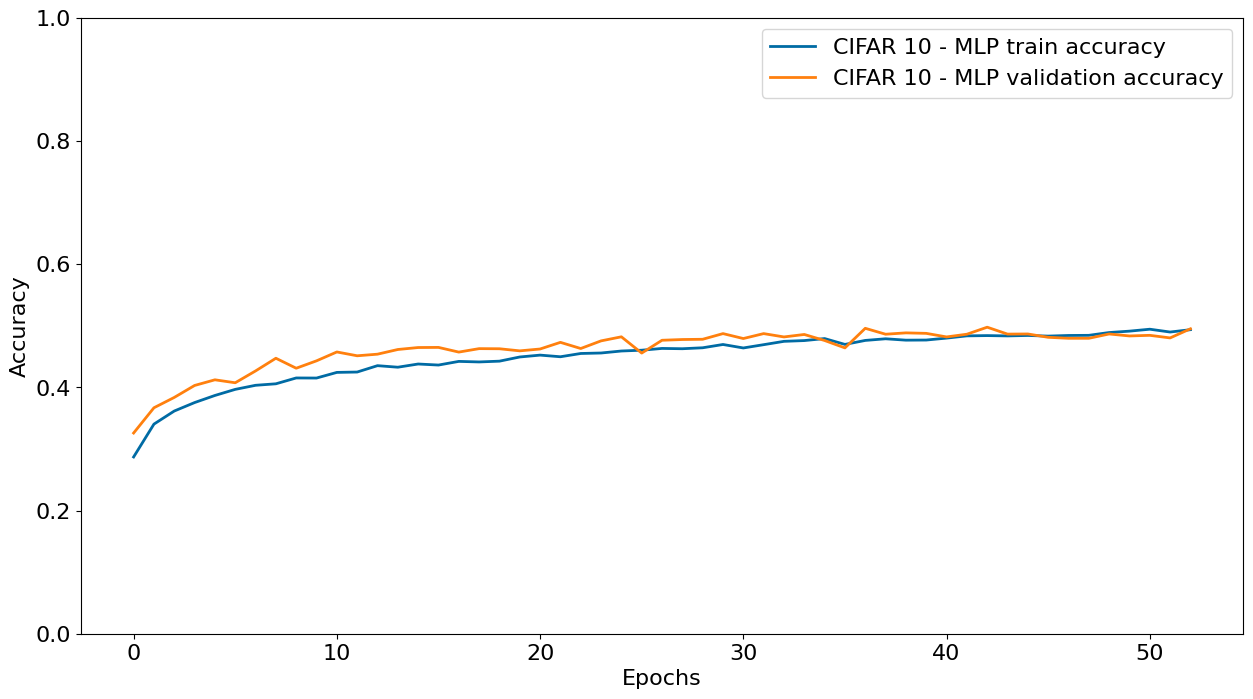

In [8]:
# # Load model and evaluate on test data. Show all the results.
# model = tf.keras.models.load_model("mlp_fmnist/with_dropout0.5_model.keras")
# mlp_eval_fmnist = model.evaluate(X_test, Y_test, verbose=1)

# # Load and plot the history
# with open('mlp_fmnist/with_dropout0.5_history.pkl', 'rb') as file:
#     loaded_history = pickle.load(file)

mlp_model_cifar10.evaluate(X_test_mlp_cifar10, Y_test_mlp_cifar10, verbose=1)

plot_history(hs={'CIFAR 10 - MLP': mlp_hs_cifar10}, metric='accuracy')

clean_up(mlp_model_cifar10)

In [14]:
# Evaluate all models
_ = evaluate_models_in_folder("mpl_cifar10/", X_test_mlp_cifar10, Y_test_mlp_cifar10, verbose=1)

## CNN

### Dataset Preprocessing for CNN CIFAR-10

In [4]:
# Load and preprocess CIFAR-10 data
X_train_cnn_cifar10 = train_images_cifar10.reshape(50000, 32,32,3)/255
X_test_cnn_cifar10 = test_images_cifar10.reshape(10000, 32,32,3)/255
input_shape = (32,32,3) # 3 channel2 and 32x32 size
X_train_cnn_cifar10 = X_train_cnn_cifar10.astype('float32')
X_test_cnn_cifar10 = X_test_cnn_cifar10.astype('float32')
Y_train_cnn_cifar10 = to_categorical(train_labels_cifar10, num_classes=10)
Y_test_cnn_cifar10 = to_categorical(test_labels_cifar10, num_classes=10)

### Train CNN CIFAR-10

In [5]:
def train_model_cnn_cifar10(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=64,
        data_augmentation=False,
        batch_normalization=False,
        num_filters=18,
        conv_layers=0,
        conv_activation='relu',
        conv_dropout=False,
        dropout_rate=0.2,
        output_activation='softmax',
        verbose=1,
        use_custom_callback=False, # if true please provide your custom callbacks list
        callbacks_list = [],
        save_model = True,
        print_summary=True,
        model_path="cnn_cifar10",
        run_name=""
):
    
    np.random.seed(1177) # Define the seed for numpy to have reproducible experiments.
    set_seed(1984) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Create model directory if it doesn't exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    if data_augmentation:
        x = RandomFlip("horizontal")(input)
        x = RandomRotation(0.1)(x)
        x = RandomZoom(0.2)(x)
    else:
        x = input

    
    # Define the convolutional layers.
    for i in range(conv_layers):
        for j in range(2):
            x = Conv2D(
                filters=num_filters*(2**i),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='same',
                dilation_rate=(1, 1),
                activation=conv_activation,
                use_bias = not batch_normalization,
                #name='Conv2D-{0:d}-{0:d}'.format(i + 1,j+1)
            )(x)
            
            #if batch_normalization: x = BatchNormalization(name='BatchNorm-{0:d}-{0:d}'.format(i + 1,j+1))(x)
            if batch_normalization: x = BatchNormalization()(x)

            
            x = Activation(activation=conv_activation)(x)
    
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=dropout_rate,
                name='Conv_Dropout-{0:d}'.format(i + 1)
            )(x)
            
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    #x = Dropout(dropout_rate)(x)

    # Add also a Dense layer
    x = Dense(128, name='Dense-{:d}'.format(1))(x)
    #x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(1))(x)
    #x = Dense(128,name='Dense-{:d}'.format(2))(x)
    x = BatchNormalization(name='BatchNorm-Dense'.format(i + 1))(x)
    x = Dropout(dropout_rate,name='Dense_Dropout-{:d}'.format(2))(x)
    
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)


    if not use_custom_callback:
       
        # Define callbacks list and paths
        log_dir = os.path.join(model_path, "logs",run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M"))
        checkpoint_path = os.path.join(model_path, run_name+"checkpoints.keras")
        
        callbacks_list = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                verbose=1,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
            ),
            TensorBoard(
                log_dir=log_dir,
                histogram_freq = 1,
                profile_batch = '500,520'
            )
        ]
        
            
    # Define the model and train it.
    model = Model(inputs=input, outputs=output, name=model_path)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', # check also if we need to use that
#                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Print a description of the model.
    if print_summary: model.summary() 
    
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        callbacks=callbacks_list, # callbacks used
        verbose=verbose,
        batch_size=batch_size
        
    )
    print('Finished training.')
    print('------------------')

    if save_model:
        # Save the model
        model.save(os.path.join(model_path, run_name+"model.keras"))
    
        # Save the training history
        with open(os.path.join(model_path, run_name+"history.pkl"), 'wb') as file:
            pickle.dump(hs, file)

    return model, hs


### Run CNN model

In [9]:
optimizer = Adam() #standard learning rate
optimizer = mp.LossScaleOptimizer(optimizer)

model_path="cnn_cifar10"
run_name="batch64+dropout02+3conv+BatchNorm+32filters+DataAug_"

# CNN
cnn_model_cifar10, cnn_hs_cifar10 = train_model_cnn_cifar10(
    train_data=X_train_cnn_cifar10,
    train_labels=Y_train_cnn_cifar10,
    optimizer=optimizer,
    epochs=100,
    batch_size=64,
    data_augmentation=True,
    num_filters=32,
    conv_layers=3,
    conv_activation='gelu',
    conv_dropout=True,
    batch_normalization=True,
    dropout_rate=0.2,
    output_activation='softmax',
    verbose=1,
    use_custom_callback=False,
    callbacks_list= [],
    save_model=True,
    print_summary=True,
    model_path=model_path,
    run_name=run_name
)

Model: "cnn_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 32, 32, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        864       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                        

2024-03-14 22:51:58.145400: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:51:58.145419: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:51:58.145432: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:51:58.145435: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:51:58.145437: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:51:58.145439: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-03-14 22:51:58.145450: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131]

Epoch 1/100
508/704 [====================>.........] - ETA: 3s - loss: 1.7376 - accuracy: 0.3911

2024-03-14 22:52:10.271559: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 22:52:10.271596: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 22:52:10.271615: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:52:10.271623: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-03-14 22:52:10.271628: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:52:10.271633: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


527/704 [=====================>........] - ETA: 3s - loss: 1.7296 - accuracy: 0.3934

2024-03-14 22:52:10.818679: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-03-14 22:52:10.824000: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2024-03-14 22:52:10.824012: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-03-14 22:52:10.824015: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:2026] function cupti_interface_->Finalize()failed with error 
2024-03-14 22:52:10.862230: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:52:10.862246: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-03-14 22:52:10.862250: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuT

704/704 [==============================] - 17s 21ms/step - loss: 1.6620 - accuracy: 0.4138 - val_loss: 1.6697 - val_accuracy: 0.4460
Epoch 2/100
704/704 [==============================] - 14s 20ms/step - loss: 1.3099 - accuracy: 0.5366 - val_loss: 1.0914 - val_accuracy: 0.6186
Epoch 3/100
704/704 [==============================] - 14s 20ms/step - loss: 1.1317 - accuracy: 0.6008 - val_loss: 1.1967 - val_accuracy: 0.6022
Epoch 4/100
704/704 [==============================] - 15s 21ms/step - loss: 1.0274 - accuracy: 0.6396 - val_loss: 0.9330 - val_accuracy: 0.6868
Epoch 5/100
704/704 [==============================] - 15s 21ms/step - loss: 0.9514 - accuracy: 0.6685 - val_loss: 0.8531 - val_accuracy: 0.7128
Epoch 6/100
704/704 [==============================] - 14s 20ms/step - loss: 0.8949 - accuracy: 0.6858 - val_loss: 0.8029 - val_accuracy: 0.7274
Epoch 7/100
704/704 [==============================] - 15s 21ms/step - loss: 0.8537 - accuracy: 0.7017 - val_loss: 0.7781 - val_accuracy: 0.73

313/313 [==============================] - 1s 3ms/step - loss: 0.4936 - accuracy: 0.8371



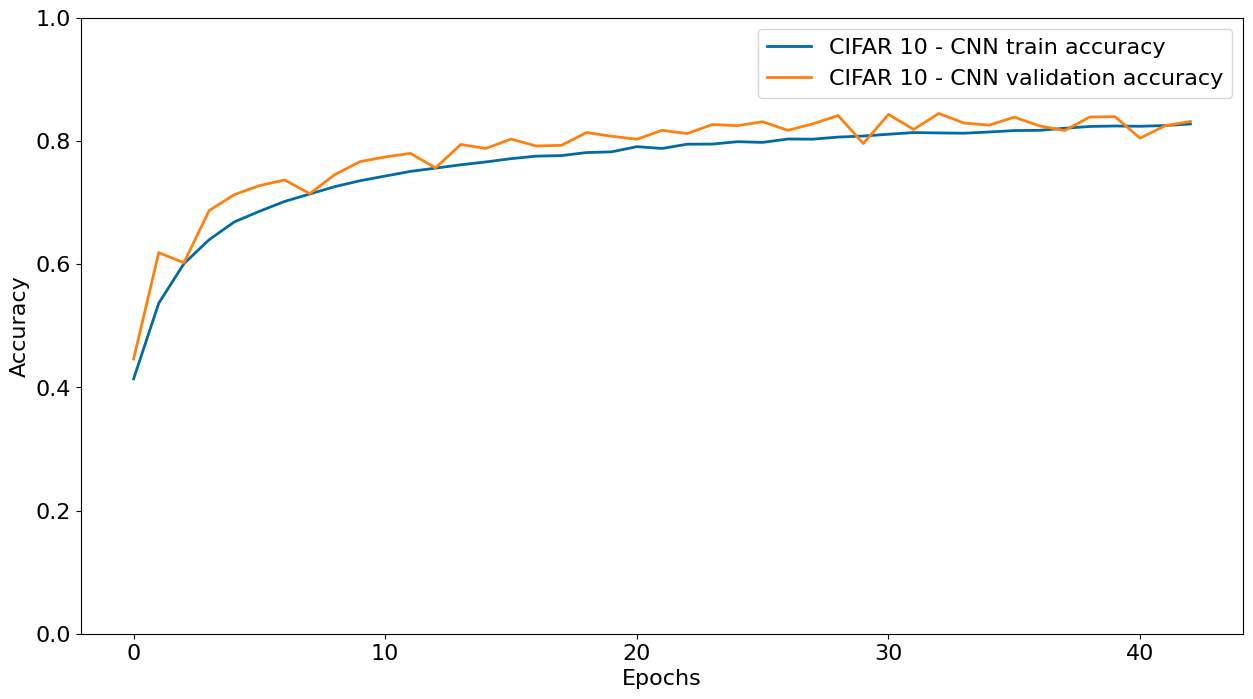

In [11]:
cnn_model_cifar10.evaluate(X_test_cnn_cifar10, Y_test_cnn_cifar10, verbose=1)

plot_history(hs={'CIFAR 10 - CNN': cnn_hs_cifar10}, metric='accuracy')

clean_up(cnn_model_cifar10)

In [10]:
#Evaluate all models
_ = evaluate_models_in_folder("cnn_cifar10/", X_test, Y_test, verbose=0)

## Hyperparamater tuning with Optuna for CNN CIFAR

In [16]:
def objective_cnn_cifar10(trial):

    tf.keras.backend.clear_session()

    callbacks_list = [
        EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=True)
    ]

    
    # Parameters to search
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    conv_layers = trial.suggest_int('hidden_layers', 2, 6, log=True)
    conv_activation = trial.suggest_categorical('hidden_activation', ['relu', 'gelu'])
    conv_filters = trial.suggest_categorical('filters',[8,16,32])
    conv_dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4])
    
    # Train the model
    optimizer = Adam(learning_rate=lr) 
    optimizer = mp.LossScaleOptimizer(optimizer)
     
    # CNN
    _ , hs = train_model_cnn_cifar10(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=50,
    batch_size=batch_size,
    data_augmentation=False,
    num_filters=conv_filters,
    conv_layers=conv_layers,
    conv_activation='gelu',
    conv_dropout=True,
    batch_normalization=True,
    dropout_rate=conv_dropout,
    output_activation='softmax',
    verbose=0,
    use_custom_callback=False,
    callbacks_list= [callbacks_list],
    save_model=False,
    print_summary=False
    )

    val_accuracy = hs.history['val_accuracy'][-1]
    return val_accuracy

In [17]:
# Define the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_cnn_cifar10, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

[I 2024-03-14 19:56:15,872] A new study created in memory with name: no-name-79f57bf8-e8f4-4b22-8a63-0d11802978e6
2024-03-14 19:56:16.071779: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 19:56:16.071799: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 19:56:16.071823: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-03-14 19:56:16.372392: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:163] cuptiEnableCallback: error 1: CUPTI_ERROR_INVALID_PARAMETER
2024-03-14 19:56:16.372412: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-03-14 19:56:16.372415: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-03-14 19:56:16.372428: E external/local_xl

KeyboardInterrupt: 